# Comparison between GPlearn SymbolicTransformer, ATGfe and LightGBM

## GPlearn SymbolicTransformer

https://gplearn.readthedocs.io/en/stable/index.html <br/>
https://gplearn.readthedocs.io/en/stable/examples.html#symbolic-transformer

In [1]:
import numpy as np
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.testing import assert_equal, assert_almost_equal
from sklearn.utils.validation import check_random_state
from gplearn.genetic import SymbolicClassifier, SymbolicRegressor
from gplearn.genetic import SymbolicTransformer
from gplearn.functions import make_function
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError

In [2]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(rmse, greater_is_better=True)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [4]:
def display_residual_plot(model, X_train, y_train, X_test, y_test):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()                 

In [5]:
def prediction_error_plot(model, X_train, y_train, X_test, y_test):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [6]:
rng = check_random_state(0)
boston = load_boston()
perm = rng.permutation(boston.target.size)
boston.data = boston.data[perm]
boston.target = boston.target[perm]

In [202]:
print('Number of features: {}'.format(boston.data.shape[1]))

Number of features: 13


In [7]:
est = Ridge()
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9,
                         random_state=0, verbose=1)
gp.fit(boston.data[:300, :], boston.target[:300])

gp_features = gp.transform(boston.data)
new_boston = np.hstack((boston.data, gp_features))

est = Ridge()
est.fit(new_boston[:300, :], boston.target[:300])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04         0.339876        6         0.822502         0.675124     44.86s
   1     6.91         0.593562        7         0.836993         0.602468     39.10s
   2     5.07         0.730093        8          0.84063         0.704017     39.35s
   3     5.22         0.735525        5         0.847019         0.628351     34.98s
   4     6.24         0.734679       10         0.856612         0.565138     33.89s
   5     8.23         0.721433       18          0.85677         0.728095     34.46s
   6    10.20         0.717937       14         0.875233         0.619693     31.62s
   7    11.84         0.720667       14         0.875927         0.609363     29.31s
   8    12.56         0.733019       27         0.881705         0.390121  

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [203]:
print('Number of features: {}'.format(new_boston.shape[1]))

Number of features: 23


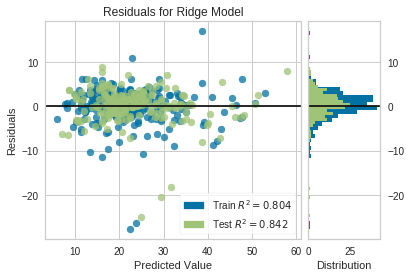

In [8]:
display_residual_plot(est, new_boston[:300, :], boston.target[:300], new_boston[300:, :], boston.target[300:])

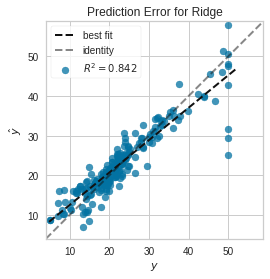

In [9]:
prediction_error_plot(est, new_boston[:300, :], boston.target[:300], new_boston[300:, :], boston.target[300:])

In [10]:
score_model(est, new_boston, boston.target)

Mean of metric: 3.910221310780306, std: 1.0984626890507385


In [11]:
est.score(new_boston[300:, :], boston.target[300:])

0.8418372105182055

## ATgfe

In [12]:
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['Y'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Y
0,0.06724,0.0,3.24,0.0,0.460,6.333,17.2,5.2146,4.0,430.0,16.9,375.21,7.34,22.6
1,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0
2,0.11425,0.0,13.89,1.0,0.550,6.373,92.4,3.3633,5.0,276.0,16.4,393.74,10.50,23.0
3,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77,8.3
4,0.05646,0.0,12.83,0.0,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,386.40,12.34,21.2


In [13]:
X = df.drop('Y', axis=1).copy()
Y = df.loc[:, 'Y'].copy()
columns = X.columns.tolist()
X_train, X_test, y_train, y_test = X.iloc[:300, :], X.iloc[300:, :], Y.iloc[:300], Y.iloc[300:]

In [14]:
def create_new_model():
    return make_pipeline(StandardScaler(), LinearRegression())

In [15]:
model = create_new_model()

In [16]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=columns,
                             number_of_candidate_features=4,
                             number_of_interacting_features=13,
                             evaluation_metric=rmse, minimize_metric=True, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=False, enable_weights=False)

2019-11-15 13:24:13,043:INFO: New Engineer created with the following parameters: 
2019-11-15 13:24:13,045:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Number of candidate features: 4
Number of interacting features: 13
Evaluation Metric: rmse
Minimize metric is True 


In [17]:
gfe.fit(population_size=2000, early_stopping_patience=10)

2019-11-15 13:24:13,725:INFO: Start of evolution 
2019-11-15 13:24:38,645:INFO:   Evaluated 2000 individuals 
2019-11-15 13:24:38,647:INFO: -- Generation 1 -- 
2019-11-15 13:24:57,967:INFO:   Evaluated 1187 individuals 
2019-11-15 13:24:57,974:INFO:   Min 4.301380725030778 
2019-11-15 13:24:57,976:INFO:   Max 1000000000000.0 
2019-11-15 13:24:57,976:INFO:   Avg 136150000004.06557 
2019-11-15 13:24:57,978:INFO:   Std 336790999729.6441 
2019-11-15 13:25:00,032:INFO: Generation: 1, validation scores: [6.11446939 5.4752214  4.16221006 4.78711105 2.89912007 3.46535319
 3.25744103 2.36752292 4.27566265 3.70859234], mean_score: 4.051270410386528 
2019-11-15 13:25:00,033:INFO: Generation: 1, best solution features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'LSTAT*PTRATIO*TAX', 'NOX + RM*TAX + RM', 'DIS/(INDUS*LSTAT*PTRATIO*TAX)', 'NOX + ZN*(-INDUS + ZN)/(AGE - INDUS)'] 
2019-11-15 13:25:00,035:INFO: -- Generation 2 -- 
2019-11-15 13:25:18

In [18]:
X_train = gfe.transform(X_train)
X_test = gfe.transform(X_test)
X = gfe.transform(X)

In [19]:
X_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTAT*(CHAS - TAX),-CHAS*(AGE*CRIM + B - TAX - ZN) + LSTAT*(NOX + RM) + RM*TAX,INDUS/(DIS*LSTAT),TAX/(DIS*(-CRIM + TAX + ZN))
300,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,-893.09,1637.208774,0.445327,0.211917
301,3.83684,0.0,18.10,0.0,0.770,6.251,91.1,2.2955,24.0,666.0,20.2,350.65,14.19,-9450.54,4262.793990,0.555672,0.438159
302,0.08387,0.0,12.83,0.0,0.437,5.874,36.6,4.5026,5.0,398.0,18.7,396.06,9.10,-3621.80,2395.282100,0.313128,0.222141
303,0.31827,0.0,9.90,0.0,0.544,5.914,83.2,3.9986,4.0,304.0,18.4,390.70,18.33,-5572.32,1916.231140,0.135072,0.250350
304,0.40202,0.0,9.90,0.0,0.544,6.382,67.2,3.5325,4.0,304.0,18.4,395.21,10.36,-3149.44,2011.881360,0.270516,0.283460


In [20]:
model = create_new_model()

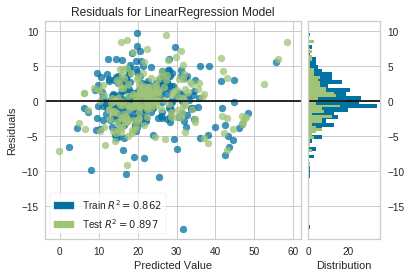

In [21]:
display_residual_plot(model, X_train, y_train, X_test, y_test)

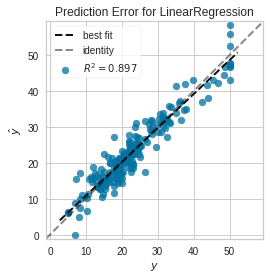

In [22]:
prediction_error_plot(model, X_train, y_train, X_test, y_test)

In [23]:
score_model(model, X, Y)

Mean of metric: 3.3250241865999945, std: 0.5520906215087776


In [24]:
model.fit(X_train, y_train);

In [25]:
r2_score(y_test, model.predict(X_test))

0.8968391382597696

# Run ATgfe with operations

In [26]:
X = gfe.transform(X)
columns = X.columns.tolist()
X_train, X_test, y_train, y_test = X.iloc[:300, :], X.iloc[300:, :], Y.iloc[:300], Y.iloc[300:]

In [27]:
model = create_new_model()

In [28]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=columns,
                             number_of_candidate_features=4,
                             number_of_interacting_features=13,
                             evaluation_metric=rmse, minimize_metric=True, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=True, enable_weights=False)

2019-11-15 13:39:55,839:INFO: New Engineer created with the following parameters: 
2019-11-15 13:39:55,841:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'LSTAT*(CHAS - TAX)', '-CHAS*(AGE*CRIM + B - TAX - ZN) + LSTAT*(NOX + RM) + RM*TAX', 'INDUS/(DIS*LSTAT)', 'TAX/(DIS*(-CRIM + TAX + ZN))', 'LSTAT*(CHAS - TAX)', '-CHAS*(AGE*CRIM + B - TAX - ZN) + LSTAT*(NOX + RM) + RM*TAX', 'INDUS/(DIS*LSTAT)', 'TAX/(DIS*(-CRIM + TAX + ZN))']
Number of candidate features: 4
Number of interacting features: 13
Evaluation Metric: rmse
Minimize metric is True 


In [29]:
np_sqrt = np.sqrt
gfe.add_transformation_operation('np_sqrt', np_sqrt)

In [30]:
gfe.fit(population_size=2000, early_stopping_patience=10)

2019-11-15 13:39:56,573:INFO: Start of evolution 
2019-11-15 13:40:05,200:INFO:   Evaluated 2000 individuals 
2019-11-15 13:40:05,201:INFO: -- Generation 1 -- 
2019-11-15 13:40:13,162:INFO:   Evaluated 1245 individuals 
2019-11-15 13:40:13,169:INFO:   Min 3.3140466773011026 
2019-11-15 13:40:13,170:INFO:   Max 100000000000.0 
2019-11-15 13:40:13,171:INFO:   Avg 5887500000.281165 
2019-11-15 13:40:13,171:INFO:   Std 21592240359.599014 
2019-11-15 13:40:15,338:INFO: Generation: 1, validation scores: [5.08673992 2.80940626 3.49118728 3.60325174 3.1257606  3.41325357
 3.32282606 2.49800253 4.85395671 2.78415367], mean_score: 3.498853834869338 
2019-11-15 13:40:15,340:INFO: Generation: 1, best solution features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'LSTAT*(CHAS - TAX)', '-CHAS*(AGE*CRIM + B - TAX - ZN) + LSTAT*(NOX + RM) + RM*TAX', 'INDUS/(DIS*LSTAT)', 'TAX/(DIS*(-CRIM + TAX + ZN))', 'LSTAT*(CHAS - TAX)', '-CHAS*(AGE*CRIM + B - TA

In [31]:
X_train = gfe.transform(X_train)
X_test = gfe.transform(X_test)
X = gfe.transform(X)

In [32]:
X_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,INDUS/(DIS*LSTAT),TAX/(DIS*(-CRIM + TAX + ZN)),LSTAT*(CHAS - TAX),-CHAS*(AGE*CRIM + B - TAX - ZN) + LSTAT*(NOX + RM) + RM*TAX,INDUS/(DIS*LSTAT),TAX/(DIS*(-CRIM + TAX + ZN)),B + log(DIS),squared(NOX),AGE*log(RAD),TAX/(DIS*NOX*(-CRIM + TAX + ZN))
300,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,...,0.445327,0.211917,-893.09,1637.208774,0.445327,0.211917,398.305509,0.199809,45.609084,0.474087
301,3.83684,0.0,18.10,0.0,0.770,6.251,91.1,2.2955,24.0,666.0,...,0.555672,0.438159,-9450.54,4262.793990,0.555672,0.438159,351.480951,0.592900,289.520704,0.569038
302,0.08387,0.0,12.83,0.0,0.437,5.874,36.6,4.5026,5.0,398.0,...,0.313128,0.222141,-3621.80,2395.282100,0.313128,0.222141,397.564655,0.190969,58.905428,0.508331
303,0.31827,0.0,9.90,0.0,0.544,5.914,83.2,3.9986,4.0,304.0,...,0.135072,0.250350,-5572.32,1916.231140,0.135072,0.250350,392.085944,0.295936,115.339691,0.460202
304,0.40202,0.0,9.90,0.0,0.544,6.382,67.2,3.5325,4.0,304.0,...,0.270516,0.283460,-3149.44,2011.881360,0.270516,0.283460,396.472006,0.295936,93.158981,0.521067


In [33]:
model = create_new_model()

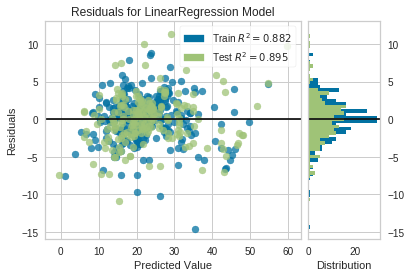

In [34]:
display_residual_plot(model, X_train, y_train, X_test, y_test)

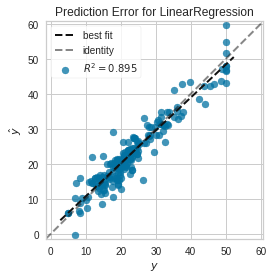

In [35]:
prediction_error_plot(model, X_train, y_train, X_test, y_test)

In [36]:
score_model(model, X, Y)

Mean of metric: 3.209043002987033, std: 0.5695992144295353


In [37]:
model.fit(X_train, y_train);

In [38]:
r2_score(y_test, model.predict(X_test))

0.8954945681256954

# LGBM

In [39]:
from lightgbm import LGBMRegressor

In [204]:
light_gbm_model = LGBMRegressor(n_estimators=250, random_state=7, reg_alpha=10)

In [205]:
X = df.drop('Y', axis=1).copy()
# X = gfe.transform(X)
Y = df.loc[:, 'Y'].copy()
columns = X.columns.tolist()
X_train, X_test, y_train, y_test = X.iloc[:300, :], X.iloc[300:, :], Y.iloc[:300], Y.iloc[300:]

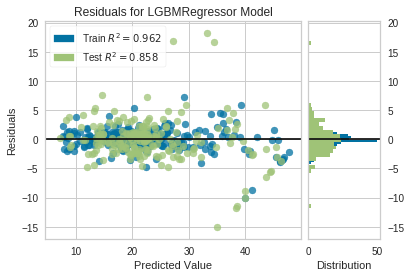

In [206]:
display_residual_plot(light_gbm_model, X_train, y_train, X_test, y_test)

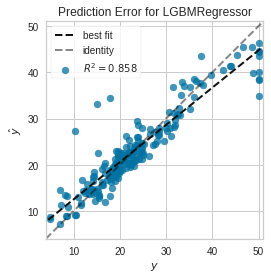

In [207]:
prediction_error_plot(light_gbm_model, X_train, y_train, X_test, y_test)

In [208]:
score_model(light_gbm_model, X, Y)

Mean of metric: 3.3802976793593134, std: 0.8444496604871627


In [209]:
X_train, X_val, y_train, y_val = X.iloc[:250, :], X.iloc[250:300, :], Y.iloc[:250], Y.iloc[250:300]

In [210]:
light_gbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[1]	valid_0's l2: 72.0908
[2]	valid_0's l2: 63.3354
[3]	valid_0's l2: 56.1829
[4]	valid_0's l2: 50.02
[5]	valid_0's l2: 45.2083
[6]	valid_0's l2: 40.915
[7]	valid_0's l2: 37.0365
[8]	valid_0's l2: 33.695
[9]	valid_0's l2: 30.851
[10]	valid_0's l2: 28.1058
[11]	valid_0's l2: 26.2033
[12]	valid_0's l2: 24.5186
[13]	valid_0's l2: 22.9227
[14]	valid_0's l2: 21.4935
[15]	valid_0's l2: 20.1784
[16]	valid_0's l2: 19.0043
[17]	valid_0's l2: 18.1695
[18]	valid_0's l2: 17.3078
[19]	valid_0's l2: 16.5481
[20]	valid_0's l2: 15.9497
[21]	valid_0's l2: 15.5086
[22]	valid_0's l2: 14.8781
[23]	valid_0's l2: 14.5453
[24]	valid_0's l2: 14.1891
[25]	valid_0's l2: 13.7807
[26]	valid_0's l2: 13.5971
[27]	valid_0's l2: 13.3433
[28]	valid_0's l2: 13.1285
[29]	valid_0's l2: 12.8266
[30]	valid_0's l2: 12.4659
[31]	valid_0's l2: 12.3469
[32]	valid_0's l2: 12.1974
[33]	valid_0's l2: 11.9343
[34]	valid_0's l2: 11.8072
[35]	valid_0's l2: 11.4855
[36]	valid_0's l2: 11.2439
[37]	valid_0's l2: 11.1807
[38]	valid_0's 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=250, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=10, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [211]:
r2_score(y_test, light_gbm_model.predict(X_test))

0.8597914119448169